In [19]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
from synthesia_video_to_midi.video_reader import VideoReader
from synthesia_video_to_midi.note_detector import PianoReader
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def to_rgb(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def show_image(frame):
    rgb = to_rgb(frame)
    plt.imshow(rgb)

def show_color(color):

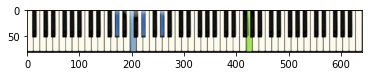

In [21]:
reader = VideoReader("Succession - Main Title Theme (Piano Tutorial) [Synthesia]-tL4B3_bQduM.mp4")
for i, frame in reader.read():
    if i > 500:
        show_image(frame[280:])
        break

In [22]:
hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

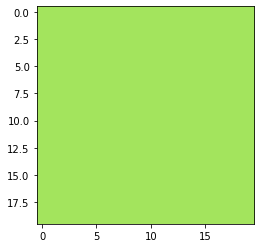

In [23]:
show_color(to_rgb(frame)[345][423])
right_hand_hue_white = hsv_frame[345][423][0]


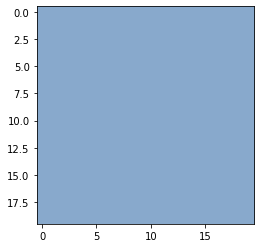

In [24]:
show_color(to_rgb(frame)[345][200])
left_hand_hue_white = hsv_frame[345][200][0]

In [25]:
piano_reader = PianoReader(right_hand_hue_white, left_hand_hue_white, 52, 36, 21, 7)

In [26]:
import math
def add_square(frame, y_x, size):
    y, x = y_x
    for cursor_y in range(size):
        for cursor_x in range(size):
            frame[cursor_y+y-(size//2)][cursor_x+x-(size//2)] = [0, 0, 255]
    return frame
def print_found_keys(detected, frame, size):
    debug_frame = frame.copy()[280:]
    for key in detected:
        debug_frame = add_square(debug_frame, key[2], size)
    show_image(debug_frame)

In [27]:
def render_debug():
    for i, frame in reader.read():
        if i > 100:
            detected = []
            piano_frame = frame[280:]
            for key in piano_reader.read(piano_frame):
                piano_frame = add_square(piano_frame, key[3], 3)
            plt.imsave(f"frames/image{i}.jpg", piano_frame)


In [28]:
hsv_frame[345][423]

array([ 44, 151, 228], dtype=uint8)

In [29]:
hsv_frame[345][200]

array([105,  85, 204], dtype=uint8)

(48, 'LEFT', 'WHITE', (65, 202))
(79, 'RIGHT', 'WHITE', (65, 424))
(44, 'LEFT', 'BLACK', (40, 173))
(51, 'LEFT', 'BLACK', (40, 223))
(56, 'LEFT', 'BLACK', (40, 259))


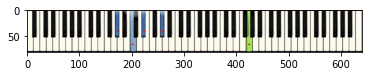

In [30]:
for i, frame in reader.read():
    if i > 500:
        show_image(frame[280:])
        break
detected = []
piano_frame = frame[280:]
for key in piano_reader.read(piano_frame):
    print(key)
    piano_frame = add_square(piano_frame, key[3], 3)
show_image(piano_frame)


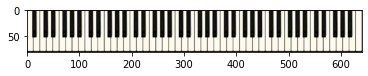

In [31]:
for i, frame in reader.read():
    if i > 2806:
        show_image(frame[280:])
        break

In [40]:
from midiutil import MIDIFile
import math

start = 94
end = 2806
fps = 30
tempo = 140
beats_per_frame = (tempo/60) / fps
tracks = {
    "LEFT": 0,
    "RIGHT": 1
}
channel  = 0
time     = 0    # In beats
volume   = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(2, removeDuplicates=False, deinterleave=True, file_format=1)  # One track, defaults to format 1 (tempo track is created
                      # automatically
MyMIDI.addTempo(0, time, tempo)
MyMIDI.addTempo(1, time, tempo)

note_tracks = {}
notes = {}

for i, frame in reader.read():
        if i > start and i < end:
            piano_frame = frame[280:]
            seen = []
            for key in piano_reader.read(piano_frame):
                degree = key[0]
                hand = key[1]
                track = tracks[hand]
                seen.append(degree)
                if degree not in notes:
                    notes[degree] = 0
                note_tracks[degree] = track
                notes[degree] += 1
            # if not seen and has beats, then add and clear
            channel = -1
            for candidate, frames in {**notes}.items():
                if candidate not in seen:
                    channel += 1
                    track = note_tracks[candidate]
                    duration = (frames) * beats_per_frame
                    time = i * beats_per_frame
                    MyMIDI.addNote(0, channel, candidate, time, duration, volume)
                    del notes[candidate]
                    del note_tracks[candidate]
                    
                    
with open("succession.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)


In [32]:
beats_per_frame

0.07777777777777778